In [ ]:
!git clone https://github.com/gachonyws/face-mask-detector.git

Cloning into 'face-mask-detector'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1302 (delta 0), reused 0 (delta 0), pack-reused 1298
Receiving objects: 100% (1302/1302), 74.61 MiB | 16.54 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [71]:
cd /content/face-mask-detector/

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-71-8877e603d0e0>", line 1, in <module>
    get_ipython().magic('cd /content/face-mask-detector/')
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-91>", line 2, in cd
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
FileNotFoundError: [Errno 2] No such file or directory

During handling of the abov

FileNotFoundError: ignored

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
#import winsound as sd

# 사진 속에서 얼굴을 탐지하는 face_detector 모델
facenet = cv2.dnn.readNet('face_detector/deploy.prototxt','face_detector/res10_300x300_ssd_iter_140000.caffemodel') 
# 얼굴을 dnn 모듈을 통해 명확히 인식하기 위해선 우선 caffe framework로 해당 이미지를 학습시켜서 자신만의 모델을 만들어야 한다.
# 그렇게 딥러닝을 통해 학습된 binary 상태의 모델 파일인 caffemodel과 해당 신경망 모델의 레이어를 구성하고 속성을 정의한 prototxt 파일을 로드해준다.
# 얼굴인식 후 마스크 착용 여부를 확인하는 모델
model = load_model('mask_detector.model')

In [ ]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

Saving maskxoxo.jpeg to maskxoxo.jpeg


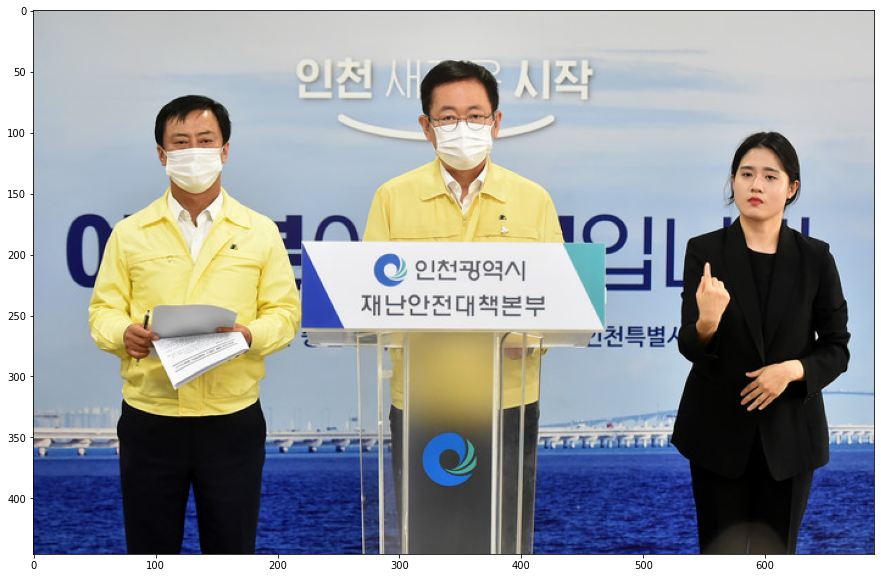

In [ ]:
img = cv2.imread('/content/face-mask-detector/examples/ma1.jpg')
img = cv2.imread('/content/face-mask-detector/examples/maskxoxo.jpeg')
#img = cv2.imread('/content/face-mask-detector/examples/example_01.png')
h,w = img.shape[:2] # h는 높이, w는 너비
plt.figure(figsize=(16,10))
plt.imshow(img[:,:,::-1]) # BGR -> RGB 변환

In [ ]:
blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0))
facenet.setInput(blob) # 모델에 들어가는 input
detections = facenet.forward() # 결과를 inference

((573, 112), (620, 170))
((104, 81), (157, 150))
((322, 56), (378, 132))


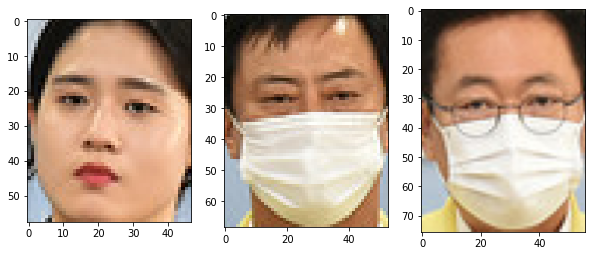

In [ ]:
faces = []
faces_point = []

# 사진속 얼굴 개수가 여러 개 있을 수 있으니 반복문 사용
for i in range(detections.shape[2]):
  confidence = detections[0,0,i,2] # 사람 얼굴을 인식했을 때 얼마나 정확도가 높은지 결과를 신뢰해도 되는지의 confidence 변수

  if confidence < 0.5:
    continue
  else:
    ## 얼굴 좌표 가져옴 ##
     x1 = int(detections[0,0,i,3] * w) 
     y1 = int(detections[0,0,i,4] * h)
     x2 = int(detections[0,0,i,5] * w)
     y2 = int(detections[0,0,i,6] * h) #  분석할 box들이 정해졌다면 이제 이 box들의 좌표 속성을 읽어들어와서 분석

     face = img[y1:y2, x1:x2] # 얼굴 이미지만 잘라내기
     faces.append(face)
     faces_point.append(((x1, y1),(x2, y2))) #얼굴 좌표 저장

plt.figure(figsize=(10,5))

for i, face in enumerate(faces): # 배열 함수 enumerate
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:, :, ::-1])

for point in faces_point:
  print(point)

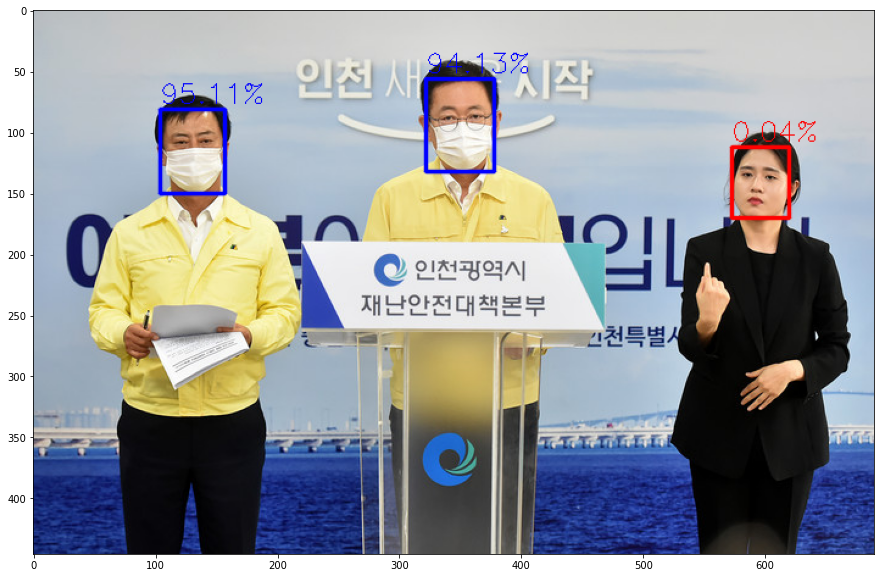

In [ ]:
import math

clone_img = img.copy()

h,w = clone_img.shape[:2] # h는 높이, w는 너비
plt.figure(figsize=(16,10))

for point in faces_point:
  #마스크 착용여부 확인
  face = clone_img[point[0][1]:point[1][1], point[0][0]:point[1][0]] # 얼굴 이미지만 잘라내기
  face_input = cv2.cvtColor(face, cv2.COLOR_BGR2RGB) # BGR을 RGB로
  face_input = cv2.resize(face_input, dsize=(224, 224))
  face_input = preprocess_input(face_input)
  face_input = np.expand_dims(face_input, axis=0)

  (mask, nomask) = model.predict(face_input)[0]
  if mask < 0.003:
    cv2.putText(clone_img, f"{mask*100:.2f}%", (point[0][0], point[0][1] - 5), cv2.FONT_HERSHEY_SIMPLEX,0.75, (0, 0, 255))
    cv2.rectangle(clone_img, pt1=point[0], pt2=point[1], thickness=2, color=(0, 0, 255), lineType=cv2.LINE_AA)
  else:
    cv2.putText(clone_img, f"{mask*100:.2f}%", (point[0][0], point[0][1] - 5), cv2.FONT_HERSHEY_SIMPLEX,0.75, (255, 0, 0))
    cv2.rectangle(clone_img, pt1=point[0], pt2=point[1], thickness=2, color=(255, 0, 0), lineType=cv2.LINE_AA)

plt.imshow(clone_img[:,:,::-1]) # BGR -> RGB 변환

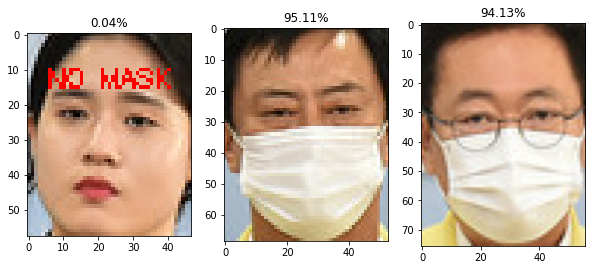

In [ ]:
plt.figure(figsize=(10,5))

for i, face in enumerate(faces):
    face_input = cv2.cvtColor(face, cv2.COLOR_BGR2RGB) # BGR을 RGB로
    face_input = cv2.resize(face_input, dsize=(224, 224))
    face_input = preprocess_input(face_input)
    face_input = np.expand_dims(face_input, axis=0)

    (mask, nomask) = model.predict(face_input)[0]

    plt.subplot(1, len(faces), i+1)
    ## 마스크 미착용자 이마에 표시 ##
    if mask*100 < 0.3: #;;
      face2 = face.copy() #;;
      cv2.putText(face2, "NO MASK", (5, 15), cv2.FONT_HERSHEY_SIMPLEX,0.25, (0, 0, 255)) #;;
      plt.imshow(face2[:, :, ::-1])#;;
    else:
      plt.imshow(face[:, :, ::-1])
    plt.title('%.2f%%' % (mask * 100))

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

cap = cv2.VideoCapture('examples/03.mp4')
ret, img = cap.read()

print(img.shape[0], img.shape[1])

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('./output.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (img.shape[1], img.shape[0]))

while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        break

    h, w = img.shape[:2]

    blob = cv2.dnn.blobFromImage(img, scalefactor=1., size=(300, 300), mean=(104., 177., 123.))
    facenet.setInput(blob)
    dets = facenet.forward()

    result_img = img.copy()

    for i in range(dets.shape[2]):
        confidence = dets[0, 0, i, 2]
        if confidence < 0.5:
            continue

        x1 = int(dets[0, 0, i, 3] * w)
        y1 = int(dets[0, 0, i, 4] * h)
        x2 = int(dets[0, 0, i, 5] * w)
        y2 = int(dets[0, 0, i, 6] * h)

        face = img[y1:y2, x1:x2]

        face_input = cv2.resize(face, dsize=(224, 224))
        face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)
        face_input = preprocess_input(face_input)
        face_input = np.expand_dims(face_input, axis=0)

        mask, nomask = model.predict(face_input).squeeze()

        if mask > nomask:
            color = (0, 255, 0)
            label = 'Mask %d%%' % (mask * 100)
        else:
            color = (0, 0, 255)
            label = 'No Mask %d%%' % (nomask * 100)

        cv2.rectangle(result_img, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=color, lineType=cv2.LINE_AA)
        cv2.putText(result_img, text=label, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=color, thickness=2, lineType=cv2.LINE_AA)

    out.write(result_img)
    #cv2_imshow(result_img) # colab 환경에서 출력 때문에 계속 Busy 상태라 ignore
    if cv2.waitKey(1) == ord('q'):
        break

out.release()
cap.release()

1080 2048


In [ ]:
from google.colab import drive
drive.mount('/content/drive')